In [1]:
# Standard Python modules
import os, sys
import yaml
from pathlib import Path
import numpy as np
import pandas as pd
import xarray as xr
# matplotlib
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1 import AxesGrid
from matplotlib import rcParams
from matplotlib.colors import ListedColormap
import matplotlib.ticker as mticker
# plot styles/formatting
import seaborn as sns
import cmocean.cm as cmo
import cmocean
# cartopy
import cartopy.crs as ccrs
from cartopy.mpl.geoaxes import GeoAxes

# Extra 
from scipy.ndimage import gaussian_filter    # smoothing contour lines
from scipy import stats

import metpy.calc as mpcalc
from metpy.units import units
from IPython.display import Image, display

# import personal modules

# Path to modules
sys.path.append('../modules')

# Import my modules
from plotter import draw_basemap
from timeseries import persistence, select_months, create_list_all_dates
from teleconnections import build_teleconnection_df
from statistical_tests import build_zscore_df, ttest_1samp_new

In [2]:
# Set up paths

path_to_data = '/home/nash/DATA/data/'                            # project data -- read only
path_to_out  = '/home/nash/DATA/repositories/AR_types/out/'       # output files (numerical results, intermediate datafiles) -- read & write
path_to_figs = '/home/nash/DATA/repositories/AR_types/figs/'      # figures

# USE pandas.options TO DISPLAY FLOATS TO TWO DECIMAL PLACES
pd.options.display.float_format = "{:,.2f}".format

In [3]:
ceofid = 'IVT'
neofs = 2 # choose number of eofs
nk = 3 # choose number of clusters

In [4]:
def ar_daily_df(ssn, nk):
    out_path = path_to_out + ceofid + '/' + ssn + '/' + 'neof' + str(neofs) + '/k' + str(nk) + '/'
    filepath = out_path + 'AR-types_ALLDAYS.csv'
    df = pd.read_csv(filepath)

    # set up datetime index
    df = df.rename(columns={'Unnamed: 0': 'date'})
    df = df.set_index(pd.to_datetime(df.date))
    
    ## Break up columns into different AR Types
    keys = []
    for k in range(nk):
        keys.append("AR_CAT{:1d}".format(k+1,))

    values = np.zeros((len(df.index)))
    dicts = dict(zip(keys, values))

    df_cat = pd.DataFrame(dicts, index=df.index)

    for k in range(nk):
        idx = (df['AR_CAT'] == k+1)
        col = "AR_CAT{:1d}".format(k+1,)
        df_cat.loc[idx, col] = 1
        
    # get total of all AR types
    df_cat['AR_ALL'] = df_cat['AR_CAT1'] + df_cat['AR_CAT2'] + df_cat['AR_CAT3']
    df_cat['AR_CAT'] = df['AR_CAT']
    
    return df_cat

In [5]:
# tele index
start_date = '1979-12-01'
end_date = '2019-05-31'

tele = build_teleconnection_df('daily', 'COND', start_date, end_date)
df_index_djfmam = select_months(tele, 12, 5)

# AR df
df_djfmam = ar_daily_df(ssn='djfmam', nk=3)

# combine ar df with tele df
print(len(df_djfmam), len(df_index_djfmam))
# join indices with AR count
new_djfmam = df_djfmam.join(df_index_djfmam)
new_djfmam

7290 7290


,AR_CAT1,AR_CAT2,AR_CAT3,AR_ALL,AR_CAT,AO,PDO,ENSO,SH
date,,,,,,,,,
1979-12-01 09:00:00,0.00,0.00,1.00,1.00,3,1,0,0,0
1979-12-02 09:00:00,1.00,0.00,0.00,1.00,1,1,0,0,0
1979-12-03 09:00:00,0.00,0.00,0.00,0.00,0,1,0,0,0
1979-12-04 09:00:00,0.00,0.00,0.00,0.00,0,1,0,0,0
1979-12-05 09:00:00,0.00,0.00,0.00,0.00,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...
2019-05-27 09:00:00,0.00,0.00,0.00,0.00,0,0,0,1,1
2019-05-28 09:00:00,0.00,0.00,0.00,0.00,0,-1,0,1,1
2019-05-29 09:00:00,0.00,0.00,0.00,0.00,0,-1,0,1,1


### Run zscore difference in proportion tests

In [6]:
# positive vs. negative
zscore_djfmam = build_zscore_df(new_djfmam)
zscore_djfmam[0]

zstat  pval
Teleconnection AR Type             
AO             AR_CAT1   3.85  0.00
               AR_CAT2   1.08  0.28
               AR_CAT3   4.69  0.00
               AR_ALL    5.98  0.00
PDO            AR_CAT1  -1.94  0.05
               AR_CAT2   1.77  0.08
               AR_CAT3   2.39  0.02
               AR_ALL    1.62  0.11
ENSO           AR_CAT1   2.29  0.02
               AR_CAT2   0.08  0.93
               AR_CAT3   4.76  0.00
               AR_ALL    4.22  0.00
SH             AR_CAT1  -2.46  0.01
               AR_CAT2  -1.78  0.08
               AR_CAT3  -2.03  0.04
               AR_ALL   -4.01  0.00

In [7]:
# positive vs. neutral
zscore_djfmam[1]

zstat  pval
Teleconnection AR Type             
AO             AR_CAT1   3.66  0.00
               AR_CAT2  -2.78  0.01
               AR_CAT3   3.41  0.00
               AR_ALL    2.17  0.03
PDO            AR_CAT1  -2.76  0.01
               AR_CAT2   1.44  0.15
               AR_CAT3  -1.48  0.14
               AR_ALL   -1.43  0.15
ENSO           AR_CAT1   0.42  0.68
               AR_CAT2  -1.97  0.05
               AR_CAT3   1.17  0.24
               AR_ALL   -0.50  0.62
SH             AR_CAT1  -0.32  0.75
               AR_CAT2  -2.38  0.02
               AR_CAT3   0.64  0.52
               AR_ALL   -1.60  0.11

In [8]:
# negative vs. neutral
zscore_djfmam[2]

zstat  pval
Teleconnection AR Type             
AO             AR_CAT1  -0.24  0.81
               AR_CAT2  -3.80  0.00
               AR_CAT3  -1.35  0.18
               AR_ALL   -3.83  0.00
PDO            AR_CAT1  -0.77  0.44
               AR_CAT2  -0.44  0.66
               AR_CAT3  -4.05  0.00
               AR_ALL   -3.21  0.00
ENSO           AR_CAT1  -2.24  0.03
               AR_CAT2  -2.02  0.04
               AR_CAT3  -4.32  0.00
               AR_ALL   -5.37  0.00
SH             AR_CAT1   1.97  0.05
               AR_CAT2  -0.74  0.46
               AR_CAT3   2.53  0.01
               AR_ALL    2.13  0.03

### Bar Plot Fractions

AR frequency is calculated as the percent AR days out of all days in a given AO, ENSO, SH, or PDO phase during December–March

e.g. (number of AR days/number of days in El Nino phase) vs. (number of AR days/# of days in Neutral)

In [9]:
cols = ['AR_CAT1', 'AR_CAT2', 'AR_CAT3', 'AR_ALL']
djfmam = new_djfmam.drop(columns=cols)
results_test = []
for i, df in enumerate([djfmam]):
    test_df = df
    print(len(test_df))
    # count the frequency of each AR type based on phase conditions
    test = test_df.groupby(['AR_CAT']).agg({'AO': 'value_counts',
                                        'PDO': 'value_counts',
                                        'ENSO': 'value_counts',
                                        'SH': 'value_counts'})
    print(test)
    test3 = test_df.agg({'AO': 'value_counts',
                                        'PDO': 'value_counts',
                                        'ENSO': 'value_counts',
                                        'SH': 'value_counts'})
    test3 = pd.concat([test3]*4, keys=[0, 1, 2, 3])
    print(test3)
    # get the frequency value
    test2 = test.div(test3, axis=0)
    print(test2)

    # put into a new dataframe and reset the index
    data=pd.DataFrame(test2*100)
    data = data.reset_index()

    # melt the dataframe to make it tidy
    results = pd.melt(data, id_vars=['AR_CAT', 'level_1'], value_vars=['AO', 'PDO', 'ENSO', 'SH'],
                      var_name='teleconnection', value_name='frequency')

    # drop rows where level_0 = 0
    # or where there is no AR
    results_test.append(results[results.AR_CAT != 0])

7290
             AO   PDO  ENSO    SH
AR_CAT                           
0      -1  1761  1691  1231  1871
        0  1729  1995  2755  1430
        1  1688  1492  1192  1877
1      -1   153   181   100   238
        0   165   243   316   143
        1   239   133   141   176
2      -1   272   290   195   372
        0   378   374   563   288
        1   316   302   208   306
3      -1   151   146    84   251
        0   183   271   342   143
        1   255   172   163   195
        AO   PDO  ENSO    SH
0 -1  2337  2308  1610  2732
   0  2455  2883  3976  2004
   1  2498  2099  1704  2554
1 -1  2337  2308  1610  2732
   0  2455  2883  3976  2004
   1  2498  2099  1704  2554
2 -1  2337  2308  1610  2732
   0  2455  2883  3976  2004
   1  2498  2099  1704  2554
3 -1  2337  2308  1610  2732
   0  2455  2883  3976  2004
   1  2498  2099  1704  2554
            AO  PDO  ENSO   SH
AR_CAT                        
0      -1 0.75 0.73  0.76 0.68
        0 0.70 0.69  0.69 0.71
        1 0.68 0.7

/home/nash/DATA/repositories/AR_types/figs/zscore_barplot.png


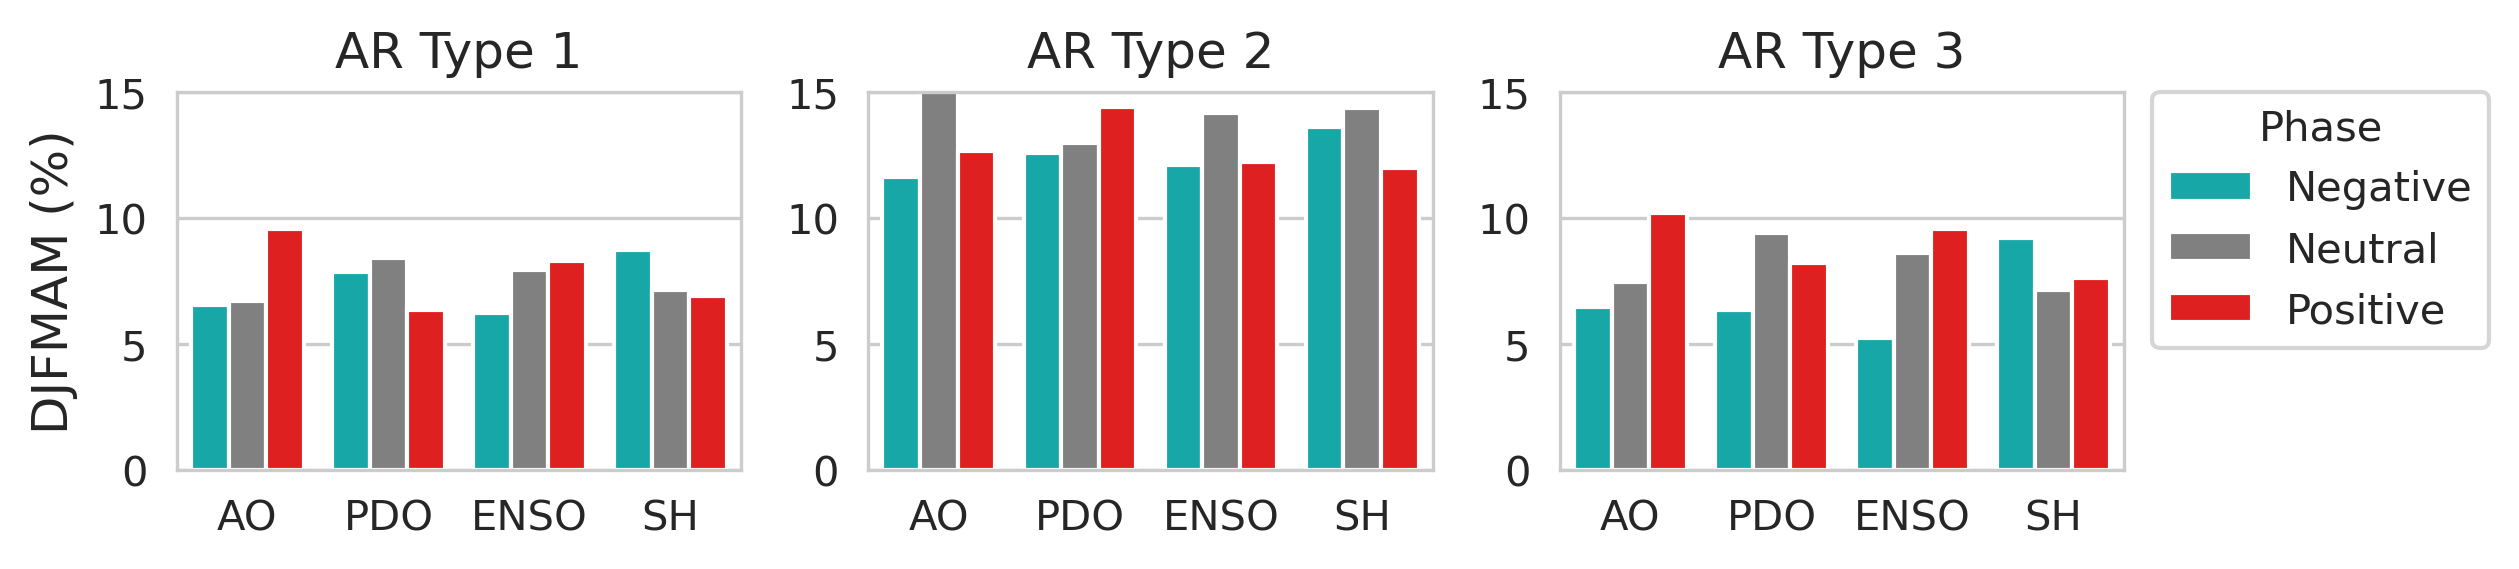

<Figure size 2550x600 with 0 Axes>

In [10]:
# TO DO: add pvalues to x-axis labels
fname = path_to_figs + 'zscore_barplot'
fmt = 'png'
fig = plt.figure()
fig.set_size_inches((8.5,2.0))
fig.dpi = 300
nrows = 1
ncols = 3
nplots=nrows*ncols

artype = [1, 2, 3]
typ_label = ['AR Type 1', 'AR Type 2', 'AR Type 3']
flatui = ['c', 'grey', 'red', ]
row_lbl1 = ['DJFMAM (%)', '', '']

sns.set_style("whitegrid")

#### DJFMAM Plots
for i, (p, ar) in enumerate(zip(np.arange(0, 3), artype)):
    sns.set_style("whitegrid")
    data = results_test[0]
    ax = plt.subplot(nrows, ncols, p+1)
    df = data[data.AR_CAT == ar]
    g = sns.barplot(x=df['teleconnection'], y=df['frequency'], hue=df["level_1"],
                data=df, palette=flatui, dodge=True, ci=None)
#     for p in g.patches[:4]:
#         g.annotate("$p$=" + format(p.get_height(), '.1f'), 
#                    (p.get_x() + p.get_width() / 2., p.get_height()), 
#                    ha = 'center', va = 'center',
#                    size=6,
#                    xytext = (0, 9), 
#                    textcoords = 'offset points')
    
    g.legend_.remove()
    sns.set_style("ticks")
    ax.set_ylabel(row_lbl1[i], fontsize=12)
    ax.set_xlabel('')
    plt.ylim(0, 15)
    ax.set_title(typ_label[i], loc='center')

# Put the legend out of the figure
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., labels=['Negative', 'Neutral', 'Positive'], title='Phase')
    

plt.tight_layout()
# Save the figure
fig.savefig('%s.%s' % (fname, fmt), bbox_inches='tight', dpi=fig.dpi)
fig.clf()

plotFile = fname + '.png'
print(plotFile)
display(Image(plotFile))